<a href="https://colab.research.google.com/github/mahdavipanah/IoT-Colab/blob/main/IoT_Colab_(Changing_12).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link to the paper https://www.sciencedirect.com/science/article/pii/S0959652621016267

Link to the slides: https://docs.google.com/presentation/d/1dhO9MWNpegfj3nEEvdvgV3j-j4GoPN5AMzw2mZ3EoIc/edit#slide=id.gf31ab12f31_0_283

Link to the paper's file: https://drive.google.com/file/d/1CokHcR_pmj7ArbuVO3c5RwixoAO8j-q0/view

In [1]:
pip install dataframe-image

     |████████████████████████████████| 1.1 MB 6.5 MB/s 
     |████████████████████████████████| 271 kB 68.1 MB/s 
     |████████████████████████████████| 192 kB 65.1 MB/s 
     |████████████████████████████████| 160 kB 56.1 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import dataframe_image as dfi
import imageio
from pathlib import Path
import os


%load_ext google.colab.data_table

from google.colab import data_table
data_table._DEFAULT_FORMATTERS[float] = lambda x: f"{x:.4f}"

In [34]:
#@title #Parameters

#@markdown Prior knowledge for the probability of the event occurrence:
PE = 0.7#@param {type:"number"}

#@markdown Selection ratio in the list of nodes:
S = 100#@param {type:"integer"}
K = 10#@param {type:"integer"}

#@markdown Number of malicious nodes:
MALICIOUS_NODES_COUNT = 10#@param {type:"integer"}

#@markdown Number of revoked nodes:
REVOKED_NODES_COUNT = 0#@param {type:"integer"}
#@markdown Probability of a revoked node to report a malicious probability:
P_REVOKE_MALICIOUS = 0.7#@param {type:"number"}

#@markdown Number of repaired nodes:
REPAIRED_NODES_COUNT = 3#@param {type:"integer"}

if (REPAIRED_NODES_COUNT > MALICIOUS_NODES_COUNT):
  raise Exception('Number of rapaired nodes can not be more than malicious count')

#@markdown The iteration to start the repairing node process:
REPAIR_ITERATION = 30#@param {type:"integer"}

#@markdown Trusted nodes probability range (inclusive):
P_START = 0.5#@param {type:"number"}
P_END = 0.99#@param {type:"number"}

#@markdown Malicious nodes probability range (inclusive):
MALICIOUS_P_START = 0.01#@param {type:"number"}
MALICIOUS_P_END = 0.49#@param {type:"number"}

#@markdown Punishment and reward for trust of nodes based on Nash EQ:
TRUST_PUNISH = 0.05#@param {type:"number"}
TRUST_REWARD = 0.03#@param {type:"number"}

#@markdown Maximum and minimum trust:
TRUST_MAX = 0.9#@param {type:"number"}
TRUST_MIN = 0.1#@param {type:"number"}

#@markdown Default Trust:
TRUST_DEFAULT = 0.5#@param {type:"number"}

#@markdown Number of iterations:
ITERATIONS_COUNT = 100#@param {type:"integer"}

#@markdown Indicates weather the code must generate plot image files or not:
GENERATE_PLOT_PNG = False#@param {type:"boolean"}

#@markdown Folder for saving plog pngs (old png files will be removed):
PLOT_PNG_FOLDER = "/content/drive/MyDrive/n-t-plot/pngs"#@param {type:"string"}

#@markdown Plot's variable:
PLOT_VARIABLE = "trust" #@param ["trust", "n_t"]

#@markdown Trust upper and lower bound for plots:
UPPER_BOUND = 0.75#@param {type:"number"}
LOWER_BOUND = 0.3#@param {type:"number"}

#@markdown Default n1 and n2 for sensors:
N1_SENSOR_DEFAULT = 1#@param {type:"integer"}
N2_SENSOR_DEFAULT = 0#@param {type:"integer"}

#@markdown Default duration for sensors:
DURATION_SENSOR_DEFAULT = 0#@param {type:"integer"}

#@markdown Malicious nodes power range:
POWER_MALICIOUS_START = 0.3#@param {type:"number"}
POWER_MALICIOUS_END = 0.6#@param {type:"number"}

#@markdown Non-malicious (trusted and revoked_ nodes power range:
POWER_NON_MALICIOUS_START = 0.7#@param {type:"number"}
POWER_NON_MALICIOUS_END = 0.98#@param {type:"number"}

In [37]:
plt.figure(figsize=(20, 5))

rng = np.random.default_rng()

def run(mal_count, repaired_nodes_count, revoked_nodes_count):
  MALICIOUS_NODES_COUNT = mal_count
  REPAIRED_NODES_COUNT = repaired_nodes_count
  REVOKED_NODES_COUNT = revoked_nodes_count

  # indices of all nodes
  nodes_indices = np.arange(S)
  # indices of malicious nodes
  malicious_indices = rng.choice(
      nodes_indices,
      size=MALICIOUS_NODES_COUNT,
      replace=False
  )

  # indices of repair nodes
  repair_indices = rng.choice(
      malicious_indices,
      size=REPAIRED_NODES_COUNT,
      replace=False
  )

  # indices of revoked nodes
  revoked_indices = rng.choice(
      np.delete(nodes_indices, malicious_indices),
      size=REVOKED_NODES_COUNT,
      replace=False
  )
  # indices of trusted nodes
  trusted_without_repaired_indices = trusted_indices = np.delete(
      nodes_indices,
      np.concatenate([malicious_indices, revoked_indices])
  )

  total_averages = np.array([])

  data_frame = pd.DataFrame()

  if GENERATE_PLOT_PNG:
    # remove old pngs plots
    [f.unlink() for f in Path(PLOT_PNG_FOLDER).glob("*.png") if f.is_file()]

  plot_list = np.array([])

  for iter in np.arange(ITERATIONS_COUNT):
    # start the repair process
    if iter == REPAIR_ITERATION:
      malicious_indices = malicious_indices[
        ~np.isin(malicious_indices, repair_indices)
      ]
      trusted_indices = np.concatenate([trusted_indices, repair_indices])

    # trusted nodes probabilities
    trusted_nodes = rng.uniform(
      P_START,
      P_END,
      len(trusted_indices),
    )
    # malicious nodes probabilities
    malicious_nodes = rng.uniform(
      MALICIOUS_P_START,
      MALICIOUS_P_END,
      len(malicious_indices),
    )
    # revoked nodes probabilities
    revoked_nodes = np.array([])
    for i in np.arange(len(revoked_indices)):
      p_start = p_end = None
      if rng.random() <= P_REVOKE_MALICIOUS:
        p_start, p_end = MALICIOUS_P_START, MALICIOUS_P_END
      else:
        p_start, p_end = P_START, P_END
      
      revoked_nodes = np.append(revoked_nodes,rng.uniform(p_start, p_end))
    
    # malicious nodes powers
    malicious_powers = rng.uniform(
      POWER_MALICIOUS_START,
      POWER_MALICIOUS_END,
      len(malicious_indices),
    )

    # non-malicious (trusted and revoked) nodes powers
    non_malicious_powers = rng.uniform(
      POWER_NON_MALICIOUS_START,
      POWER_NON_MALICIOUS_END,
      len(trusted_indices) + len(revoked_indices),
    )

    nodes = np.array([])
    powers = np.array([])
    for i in np.arange(S):
      elem = None
      power = None

      if np.any(np.isin(malicious_indices, i)):
        elem, malicious_nodes = malicious_nodes[0], np.delete(malicious_nodes, 0)

        power, malicious_powers = malicious_powers[0], np.delete(malicious_powers, 0)
      elif np.any(np.isin(revoked_indices, i)):
        elem, revoked_nodes = revoked_nodes[0], np.delete(revoked_nodes, 0)

        power, non_malicious_powers = non_malicious_powers[0], np.delete(non_malicious_powers, 0)
      else:
        elem, trusted_nodes = trusted_nodes[0], np.delete(trusted_nodes, 0)

        power, non_malicious_powers = non_malicious_powers[0], np.delete(non_malicious_powers, 0)

      nodes = np.append(nodes, elem)
      powers = np.append(powers, power)

    data_frame['probability'] = nodes
    data_frame['power'] = powers

    if iter == 0:
      data_frame['trust'] = TRUST_DEFAULT
      data_frame['duration'] = DURATION_SENSOR_DEFAULT
      data_frame['n1'] = N1_SENSOR_DEFAULT
      data_frame['n2'] = N2_SENSOR_DEFAULT
      data_frame['n_t'] = N1_SENSOR_DEFAULT / (
          N1_SENSOR_DEFAULT + N2_SENSOR_DEFAULT
      )
      data_frame['N1'] = 0
      data_frame['N2'] = 0
      data_frame['trust average'] = 0
    
    # generate plot image files
    if GENERATE_PLOT_PNG or iter == ITERATIONS_COUNT - 1:
      plt.clf()
      plt.scatter(
          trusted_without_repaired_indices,
          data_frame.loc[trusted_without_repaired_indices, PLOT_VARIABLE].values,
          color="green",
          label= 'Trusted nodes',
      )
      if iter >= REPAIR_ITERATION:
        plt.scatter(
            repair_indices,
            data_frame.loc[repair_indices, PLOT_VARIABLE].values,
            color="blue",
            label= 'Repaired nodes',
        )
      plt.scatter(
          malicious_indices,
          data_frame.loc[malicious_indices, PLOT_VARIABLE].values,
          color="red",
          label= 'Malicious nodes',
      )
      plt.scatter(
          revoked_indices,
          data_frame.loc[revoked_indices, PLOT_VARIABLE].values,
          color="orange",
          label= 'Revoked nodes',
      )
      plt.ylim(0, 1)
      plt.xlim(0, S - 1)
      plt.xlabel('Node ID', fontsize=18)
      plt.ylabel("Node's " + PLOT_VARIABLE, fontsize=18)
      plt.axhline(UPPER_BOUND, color="green", label="Upper bound")
      plt.axhline(LOWER_BOUND, color="orange", label="Lower bound")
      plt.grid()
      plt.title(f'Round {iter + 1}')
      plt.suptitle(f'PE: {PE} - Rounds: {ITERATIONS_COUNT} - Repair round: {REPAIR_ITERATION} - Trusted count: {len(trusted_indices)} - Malicious count: {MALICIOUS_NODES_COUNT} - Revoked count: {REVOKED_NODES_COUNT} - Repair count: {REPAIRED_NODES_COUNT}')
      png_filename = os.path.join(PLOT_PNG_FOLDER, str(iter) + '.png')
      plt.legend()
      plt.savefig(png_filename)
      plot_list = np.append(plot_list, png_filename)

    for n in np.arange(S//K):
      # indecies of the n-th E-Sensor
      sensor_indices = np.arange(n * K, n * K + K)
      
      for i in sensor_indices:
        i_prob = data_frame.at[i, 'probability']

        # indices of other nodes of the sensor
        others_indices = np.delete(
          sensor_indices,
          np.where(sensor_indices == i)
        )

        # average of other nodes of the sensor
        others_average = np.mean(
            data_frame.loc[others_indices, 'probability'].values
        )
        data_frame.at[i, 'average'] = others_average

        # cost1nodes_indices
        i_cost1 = (i_prob - others_average) ** 2
        data_frame.at[i, 'cost1'] = i_cost1
        
        # cost2 calculations
        consistant_t = 1
        non_consistent_t = 1
        
        for j in others_indices:
          j_prob = data_frame.at[j, 'probability']

          condition = (j_prob - 0.5) * (PE - 0.5)
          
          if condition < 0:
            consistant_t *= j_prob
          else:
            non_consistent_t *= j_prob
        
        pi_et = ((PE * consistant_t) /
                (PE * consistant_t + (1 - PE) * non_consistent_t))

        i_cost2 = (i_prob - pi_et) ** 2
        data_frame.at[i, 'cost2'] = i_cost2

        # utility
        data_frame.at[i, 'utility'] = i_cost1 + i_cost2


      # min utility
      argmin = np.min(
          data_frame.loc[sensor_indices, 'utility'].values
      ) 
      data_frame.loc[sensor_indices, 'min utility'] = argmin
      # max utility
      argmax = np.max(
          data_frame.loc[sensor_indices, 'utility'].values
      )
      data_frame.at[sensor_indices, 'max utility'] = argmax
      # average utility
      average = np.mean(
          data_frame.loc[sensor_indices, 'utility'].values
      )
      data_frame.at[sensor_indices, 'average utility'] = average

      th_tail = (argmin + argmax) / 2
      th_head = argmin - (argmin / 2)

      for i in sensor_indices:
        i_prob = data_frame.at[i, 'probability']
        i_trust = data_frame.at[i, 'trust']

        i_new_trust = None

        condition_base = i_prob >= th_head and i_prob <= th_tail
        if condition_base if PE >= 0.5 else not(condition_base):
          # increase sensor's n2
          data_frame.at[i, 'n2'] += 1

          # punish sensor's trust
          if i_trust - TRUST_PUNISH > TRUST_MIN:
            i_new_trust = i_trust - TRUST_PUNISH
          else:
            i_new_trust = TRUST_MIN
        else:
          # increase sensor's n1
          data_frame.at[i, 'n1'] += 1

          # reward sensor's trust
          if i_trust + TRUST_REWARD < TRUST_MAX:
            i_new_trust = i_trust + TRUST_REWARD
          else:
            i_new_trust = TRUST_MAX
        
        data_frame.at[i, 'trust'] = i_new_trust

        data_frame.at[i, 'n_t'] = data_frame.at[i, 'n1'] / (
            data_frame.at[i, 'n1'] + data_frame.at[i, 'n2']
        )

        data_frame.at[i, 'duration'] += 1
      
      # update e-node's N1 and N2
      N1 = data_frame.loc[sensor_indices, 'N1'] = np.sum(
          data_frame.loc[sensor_indices, 'n1'].values
      )
      N2 = data_frame.loc[sensor_indices, 'N2'] = np.sum(
          data_frame.loc[sensor_indices, 'n2'].values
      )
      # update e-node's N_T
      data_frame.loc[sensor_indices, 'N_T'] = N1 / (N1 + N2)

      # update e-node's trust average
      data_frame.loc[sensor_indices, 'trust average'] = np.average(
          data_frame.loc[sensor_indices, 'trust'].values
      )
    
    # trust average of the system in each iteration
    total_average = data_frame['system trust average'] = np.average(
        data_frame['trust'].values
    )

    total_averages = np.append(total_averages, total_average)

  return data_frame, total_averages

<Figure size 1440x360 with 0 Axes>

In [ ]:
data_frame, total_averages = run(MALICIOUS_NODES_COUNT, REPAIRED_NODES_COUNT, REVOKED_NODES_COUNT)

data_frame

Mean  0.17060361471323585
std 0.177557925689763
 The utility should be between-0.006954310976527156and0.34816154040299885


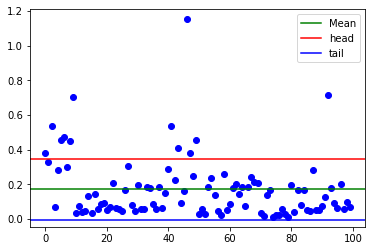

In [6]:
std = data_frame['utility'].std()
mn = data_frame['utility'].mean() 
plt.scatter(np.arange(0,100,1), data_frame['utility'] .values, marker='o', c = 'b')


plt.axhline(mn, c = 'g', label = 'Mean')
plt.axhline(mn + std, c = 'r', label = 'head')
plt.axhline(mn - std, c = 'b', label= 'tail')


plt.legend()
print('Mean ', mn)
print('std',std)
print( ' The utility should be between' + str(mn- std) + 'and' +str(mn+ std))

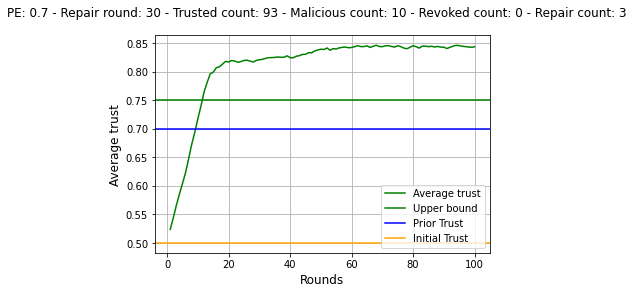

In [7]:
plt.plot(np.arange(1, ITERATIONS_COUNT + 1), total_averages, label = 'Average trust', c= 'g')
plt.axhline(UPPER_BOUND, color="green", label="Upper bound")
#plt.axhline(LOWER_BOUND, color="Red", label="Lower bound")
plt.axhline(PE, color="Blue", label="Prior Trust")
plt.axhline(0.5, color="Orange", label="Initial Trust ")
plt.xlabel('Rounds', fontsize=12)
plt.ylabel("Average trust", fontsize=12)
#plt.title('  Evaluation of the game theory model ')
plt.suptitle(f'PE: {PE} - Repair round: {REPAIR_ITERATION} - Trusted count: {len(trusted_indices)} - Malicious count: {MALICIOUS_NODES_COUNT} - Revoked count: {REVOKED_NODES_COUNT} - Repair count: {REPAIRED_NODES_COUNT}')
plt.legend()
plt.grid()

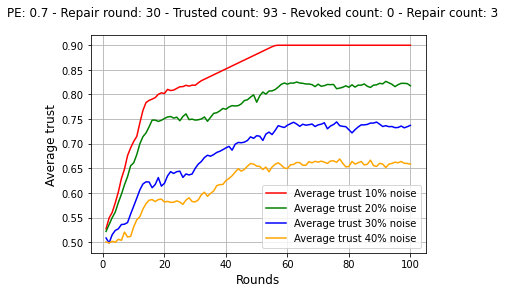

In [32]:
colors = ['red', 'green', 'blue', 'orange']
mal_counts = [10, 20, 30, 40]
total_averages = []
for i in range(4):
  data_frame, total_average = run(S * mal_counts[i] // 100)
  total_averages.append(total_average)

indexes = np.arange(1, ITERATIONS_COUNT + 1);
plt.clf()
for i in range(4):
  plt.plot(indexes, total_averages[i], label = f'Average trust {mal_counts[i]}% noise', c= colors[i])

plt.xlabel('Rounds', fontsize=12)
plt.ylabel("Average trust", fontsize=12)
plt.suptitle(f'PE: {PE} - Repair round: {REPAIR_ITERATION} - Trusted count: {len(trusted_indices)} - Revoked count: {REVOKED_NODES_COUNT} - Repair count: {REPAIRED_NODES_COUNT}')
plt.legend()
plt.grid()

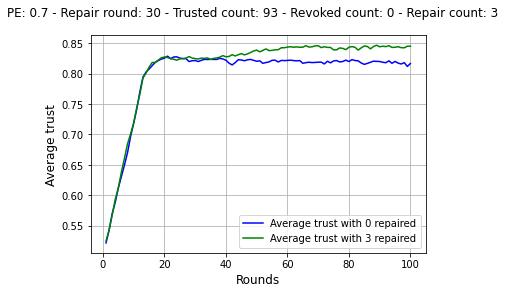

In [36]:
mal_count = S * 10 // 100
_, total_average_without_repaired = run(mal_count, 0)
_, total_average_with_repaired = run(mal_count, 3)

indexes = np.arange(1, ITERATIONS_COUNT + 1);
plt.clf()
plt.plot(indexes, total_average_without_repaired, label=f'Average trust with 0 repaired', c='blue')
plt.plot(indexes, total_average_with_repaired, label=f'Average trust with 3 repaired', c='green')

plt.xlabel('Rounds', fontsize=12)
plt.ylabel("Average trust", fontsize=12)
plt.suptitle(f'PE: {PE} - Repair round: {REPAIR_ITERATION} - Trusted count: {len(trusted_indices)} - Revoked count: {REVOKED_NODES_COUNT} - Repair count: {REPAIRED_NODES_COUNT}')
plt.legend()
plt.grid()

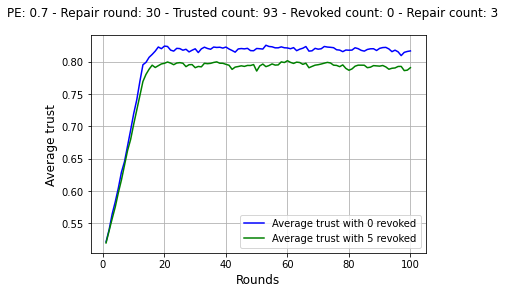

In [38]:
mal_count = S * 10 // 100
_, total_average_without_revoked = run(mal_count, 0, 0)
_, total_average_with_revoked = run(mal_count, 0, 5)

indexes = np.arange(1, ITERATIONS_COUNT + 1);
plt.clf()
plt.plot(indexes, total_average_without_revoked, label=f'Average trust with 0 revoked', c='blue')
plt.plot(indexes, total_average_with_revoked, label=f'Average trust with 5 revoked', c='green')

plt.xlabel('Rounds', fontsize=12)
plt.ylabel("Average trust", fontsize=12)
plt.suptitle(f'PE: {PE} - Repair round: {REPAIR_ITERATION} - Trusted count: {len(trusted_indices)} - Revoked count: {REVOKED_NODES_COUNT} - Repair count: {REPAIRED_NODES_COUNT}')
plt.legend()
plt.grid()

In [8]:
import cv2
from pathlib import Path

if GENERATE_PLOT_PNG:
  image_folder = PLOT_PNG_FOLDER
  video_name = 'repair.avi'
  video_path = os.path.join(Path(image_folder).parent, video_name)

  images = [
    img for img in os.listdir(image_folder) if img.endswith(".png")
    ]
  images.sort(key=lambda x: int(x[:-4]))
  frame = cv2.imread(os.path.join(image_folder, images[0]))
  height, width, layers = frame.shape

  video = cv2.VideoWriter(video_path, 0, 1, (width,height))

  for image in images:
      video.write(cv2.imread(os.path.join(image_folder, image)))

  cv2.destroyAllWindows()
  video.release()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


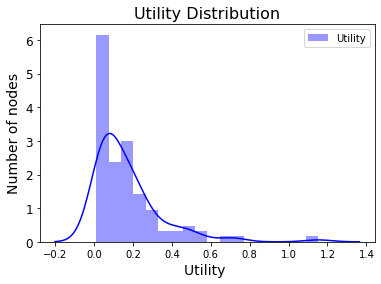

In [9]:
import seaborn as sb # visualization 
# 3. Distribution plot

sb.distplot(data_frame['utility'], color = 'b', label = 'Utility')
plt.title('Utility Distribution', fontsize = 16)
plt.xlabel('Utility ', fontsize = 14)
plt.ylabel('Number of nodes', fontsize = 14)
#plt.xticks(fontsize = 1)
plt.yticks(fontsize = 12)
plt.legend()